In [78]:
# Time Series Prediction with LSTM
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [79]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)

In [80]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [81]:
# load the dataset
dataset_name = "q1"
product_name = "no2"
file_path = 'dataset/'+dataset_name+'.csv'
dataframe = pd.read_csv(file_path)
print("Dataframe: \n", dataframe)
dataset = numpy.asarray(dataframe[product_name]*1000000).reshape(-1,1)
print("Dataset: \n", dataset)


Dataframe: 
             date dist        co       no2        o3  so2  ch4      hcho
0     2018-04-30   q1  0.036519  0.000059  0.127509  0.0    0  0.000000
1     2018-05-01   q1  0.035765  0.000053  0.128756  0.0    0  0.000000
2     2018-05-02   q1  0.037218  0.000051  0.127053  0.0    0  0.000000
3     2018-05-03   q1  0.000000  0.000000  0.120879  0.0    0  0.000000
4     2018-05-04   q1  0.000000  0.000000  0.121712  0.0    0  0.000000
...          ...  ...       ...       ...       ...  ...  ...       ...
1194  2021-08-06   q1  0.000000  0.000000  0.120559  0.0    0  0.000000
1195  2021-08-07   q1  0.020865  0.000000  0.119257  0.0    0  0.000000
1196  2021-08-08   q1  0.025278  0.000000  0.118261  0.0    0  0.000000
1197  2021-08-09   q1  0.000000  0.000000  0.120582  0.0    0  0.000295
1198  2021-08-10   q1  0.026092  0.000000  0.120392  0.0    0  0.000000

[1199 rows x 8 columns]
Dataset: 
 [[58.98750896]
 [53.16329407]
 [50.91739149]
 ...
 [ 0.        ]
 [ 0.        ]
 [ 0.  

In [82]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print("Dataset after scale: \n", dataset)

Dataset after scale: 
 [[0.30101245]
 [0.27129156]
 [0.25983075]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


In [83]:
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [84]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print("TrainX shape: ", trainX.shape)
print("TrainY shape: ", trainY.shape)

TrainX shape:  (1077, 1)
TrainY shape:  (1077,)


In [85]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [86]:
# create and fit the LSTM network
model = Sequential()
model.add(Dense(4, input_shape=(1, look_back)))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2,
          validation_data=(testX, testY))

score = model.evaluate(testX, testY, verbose=0)
print('score: test score = ', score)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1, 4)              8         
_________________________________________________________________
dense_22 (Dense)             (None, 1, 1)              5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
108/108 - 1s - loss: 0.0627 - val_loss: 0.0245
Epoch 2/100
108/108 - 0s - loss: 0.0450 - val_loss: 0.0192
Epoch 3/100
108/108 - 0s - loss: 0.0397 - val_loss: 0.0166
Epoch 4/100
108/108 - 0s - loss: 0.0380 - val_loss: 0.0154
Epoch 5/100
108/108 - 0s - loss: 0.0375 - val_loss: 0.0157
Epoch 6/100
108/108 - 0s - loss: 0.0375 - val_loss: 0.0156
Epoch 7/100
108/108 - 0s - loss: 0.0374 - val_loss: 0.0162
Epoch 8/100
108/108 - 0s - loss: 0.0373 - val_loss: 0.0152
Epoch 9/100
108/108 - 0s - loss: 0.0376 - v

In [87]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [96]:
# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

(1077, 1)


ValueError: Found array with dim 3. Estimator expected <= 2.

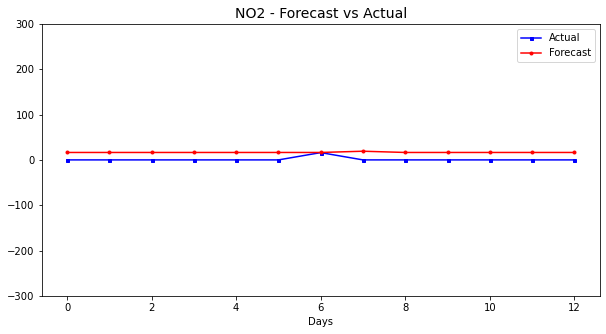

In [ ]:
test_Y = testY[0][len(testY[0])-14:len(testY[0])-1]
test_Ypred = testPredict[len(testPredict)-14:len(testPredict)-1]
plt.subplots(figsize=(10, 5))
plt.title(product_name.upper() + " - Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(numpy.ravel(test_Y)), "bs-", markersize=3, label="Actual")
plt.plot(pd.Series(numpy.ravel(test_Ypred)), "ro-", markersize=3, label="Forecast")
plt.legend(loc="best")
plt.xlabel("Days")
plt.ylim([-300,300])
plt.show()

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.8f RMSE' % (trainScore), trainY.max(), trainY.min())
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.8f RMSE' % (testScore), testY.max(), testY.min(), testY.mean())

Train Score: 37.76895708 RMSE 195.96368656493723 0.0
Test Score: 25.23670147 RMSE 127.11838644463569 0.0 8.054272904577743


In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

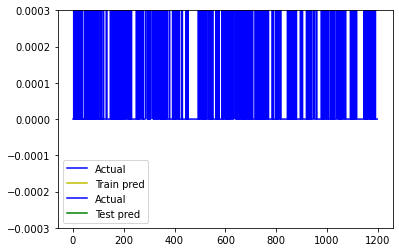

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),"b-", label="Actual")
plt.plot(trainPredictPlot,"y-", label="Train pred")
plt.plot(scaler.inverse_transform(testY)[0],"b-", label="Actual")
plt.plot(testPredictPlot, "g-", label="Test pred")
plt.legend(loc="best")
plt.ylim([-0.0003,0.0003])
plt.show()
